# PROJECT : Trading at Close
# Submission by Saksham Jain

## To Develop a model capable of predicting the closing price movements for hundreds of Nasdaq listed stocks using data from the order book and the closing auction of the stock. 

##### Data Processing and Feature Engineering:

The code starts by reading and processing training data, including handling missing values and resetting the DataFrame index.
It then defines functions for reducing memory usage and calculating triplet imbalance features based on stock prices.
##### Feature Generation:

Features are generated for various financial metrics such as price, size, imbalance, and momentum.
Weighted averages and ratios are calculated to capture different aspects of market dynamics.
LightGBM Model Training:

The code trains LightGBM models using k-fold cross-validation, considering specific folds for training and validation.
The model is configured to optimize for mean absolute error (MAE), and its performance is evaluated on the validation set.
Neural Network Model Training:

A neural network (NN) model is defined using TensorFlow and Keras for continuous and categorical features.
The NN is trained using a group-wise forward fill method to handle NaN values and a custom time series split for cross-validation.
##### Ensemble of Models:

The code creates an ensemble of LightGBM and neural network models to capture diverse patterns and enhance predictive performance.
Inference Process:

For each test batch, the code accumulates test data and generates features.
Model predictions, including both LightGBM and NN, are combined using a weighted average approach.
The final predictions are adjusted, clipped, and submitted using the Optiver competition environment.
Performance Monitoring:

The code monitors the time taken for each iteration and reports the average queries per second.

In [1]:
# Importing libraries
import gc
import os
import time
import warnings
import joblib
import lightgbm as lgb
import numpy as np
import pandas as pd
import polars as pl
import tensorflow as tf
import Input, Embedding, Flatten, concatenate, BatchNormalization, Dropout, Dense, ReLU
from sklearn.metrics import mean_absolute_error
from itertools import combinations
from warnings import simplefilter
from tensorflow.keras.regularizers import l2
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold, TimeSeriesSplit
from tensorflow.keras.layers 
from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import he_normal
from sklearn.model_selection._split import _BaseKFold, indexable, _num_samples
from sklearn.utils.validation import _deprecate_positional_args
from numba import njit, prange
from itertools import combinations
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

# Suppressing warnings
warnings.filterwarnings("ignore")
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

# Configuration settings
config = {
    'is_offline': False,
    'LGB': True,
    'NN': False,
    'is_train': True,
    'is_infer': True,
    'max_lookback': np.nan,
    'split_day': 435
}

# Unpack configuration settings
is_offline, LGB, NN, is_train, is_infer, max_lookback, split_day = config.values()


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


# **Utility Functions**

### Parameters
#### n (int): An integer representing the number of weights to be generated.
### Algorithm
#### Initialize an empty list called weights to store the generated weights.
#### Iterate over the range from 1 to n + 1.
#### For each iteration, calculate the exponent based on the current index:
#### If the index is 1, set the exponent to 2.
#### Otherwise, set the exponent to the current index.
#### Calculate the weight using the formula: 1 / (2 ** (n + 1 - exponent)).
#### Append the calculated weight to the weights list.
#### Return the list of generated weights.

In [2]:
def generate_weights(n):
    return [1 / (2 ** (n + 1 - (2 if i == 1 else i))) for i in range(1, n + 1)]

# Example usage:
n = 5
weights = generate_weights(n)
print(weights)


#### Time Series cross-validator variant with non-overlapping groups. Allows for a gap in groups to avoid potentially leaking info from train into test if the model has windowed or lag features. Provides train/test indices to split time series data samples that are observed at fixed time intervals according to a third-party provided group. In each split, test indices must be higher than before, and thus shuffling in cross validator is inappropriate. This cross-validation object is a variation of :class:`KFold`. In the kth split, it returns first k folds as train set and the (k+1)th fold as test set. The same group will not appear in two different folds (the number of distinct groups has to be at least equal to the number of folds). Note that unlike standard cross-validation methods, successive training sets are supersets of those that come before them. Read more in the :ref:`User Guide <cross_validation>`.

# **PurgedGroupTimeSeriesSplit Class**

### Parameters:
- `n_splits`: Number of splits (default: 5).
- `max_train_group_size`: Maximum group size for a single training set (default: np.inf).
- `max_test_group_size`: Maximum group size for a single testing set (default: np.inf).
- `group_gap`: Gap between train and test (default: None).
- `verbose`: If True, display progress information during the split (default: False).


In [3]:
class CustomGroupTimeSeriesSplit(_BaseKFold):
    @_deprecate_positional_args
    def __init__(self, num_splits=5, *, max_train_group_size_custom=np.inf,
                 max_test_group_size_custom=np.inf, group_gap_custom=None, verbose_custom=False):
        super().__init__(num_splits, shuffle=False, random_state=None)
        self.max_train_group_size_custom = max_train_group_size_custom
        self.group_gap_custom = group_gap_custom
        self.max_test_group_size_custom = max_test_group_size_custom
        self.verbose_custom = verbose_custom

    def split(self, data_X, data_y=None, data_groups=None):
        if data_groups is None:
            raise ValueError("The 'data_groups' parameter should not be None")

        data_X, data_y, data_groups = indexable(data_X, data_y, data_groups)
        num_samples = _num_samples(data_X)
        num_splits = self.num_splits
        group_gap_custom = self.group_gap_custom
        max_test_group_size_custom = self.max_test_group_size_custom
        max_train_group_size_custom = self.max_train_group_size_custom
        num_folds = num_splits + 1
        group_dict_custom = {}

        # Identify unique groups and their indices
        unique_vals, indices = np.unique(data_groups, return_index=True)
        unique_groups_custom = unique_vals[np.argsort(indices)]
        num_groups_custom = _num_samples(unique_groups_custom)

        # Populate a dictionary with group indices
        for idx_custom in np.arange(num_samples):
            if data_groups[idx_custom] in group_dict_custom:
                group_dict_custom[data_groups[idx_custom]].append(idx_custom)
            else:
                group_dict_custom[data_groups[idx_custom]] = [idx_custom]

        if num_folds > num_groups_custom:
            raise ValueError(f"Number of folds ({num_folds}) cannot be greater than the number of groups ({num_groups_custom}).")

        group_test_size_custom = min(num_groups_custom //


##### Reduce_mem_usage function you provided is a memory optimization utility for reducing the memory usage of a pandas DataFrame. It works by iteratively checking the minimum and maximum values of each numeric column and converting the column to the smallest possible numeric data type that can represent that range. This helps to reduce memory usage without compromising data integrity.

In [4]:
def optimize_memory_usage(data_frame, display_info=False):
    def optimize_numeric_dtype(column, min_val, max_val):
        numeric_types = [np.int8, np.int16, np.int32, np.int64, np.float32]
        for dtype in numeric_types:
            if min_val > np.iinfo(dtype).min and max_val < np.iinfo(dtype).max:
                return column.astype(dtype)
        return column

    initial_memory = data_frame.memory_usage().sum() / 1024**2

    for column_name in data_frame.columns:
        column_type = data_frame[column_name].dtype

        if column_type != object:
            min_val, max_val = data_frame[column_name].min(), data_frame[column_name].max()

            if str(column_type)[:3] == "int":
                data_frame[column_name] = optimize_numeric_dtype(data_frame[column_name], min_val, max_val)
            else:
                data_frame[column_name] = optimize_numeric_dtype(data_frame[column_name], min_val, max_val)

    if display_info:
        print(f"Initial memory usage of the dataframe: {initial_memory:.2f} MB")
        final_memory = data_frame.memory_usage().sum() / 1024**2
        print(f"Memory usage after optimization: {final_memory:.2f} MB")
        reduction_percentage = 100 * (initial_memory - final_memory) / initial_memory
        print(f"Reduced memory usage by: {reduction_percentage:.2f}%")

    return data_frame

# Loading the Dataset


Reading CSV File:

The pd.read_csv function is used to read a CSV file located at the specified file_path into a pandas DataFrame (df).
Dropping Rows with Missing Values:

The dropna method is used to remove rows with missing values in the "target" column. The subset parameter is set to ["target"] to specify that only the "target" column should be considered for missing values.
Resetting DataFrame Index:

The reset_index method is used to reset the DataFrame index. The drop=True parameter is set to remove the old index column, and inplace=True is used to modify the DataFrame in place.
Retrieving Updated DataFrame Shape:

The shape attribute is used to retrieve the updated shape of the DataFrame after the previous operations. The resulting shape is stored in the variable df_shape.


In [5]:
# Define CSV file path
file_path = "/kaggle/input/optiver-trading-at-the-close/train.csv"

# Load CSV into DataFrame and drop rows with missing values in the "target" column
df = pd.read_csv(file_path).dropna(subset=["target"]).reset_index(drop=True)

# Get the shape of the updated DataFrame
df_shape = df.shape


**Outlier removal**

In [6]:
# Outlier Removal

```python
# Outlier Days
outlier_days = [
    33, 35, 83, 86, 96, 119, 122, 158, 193, 196,
    208, 221, 225, 283, 322, 328, 334, 346, 404,
    407, 458, 470, 474
]

# Remove rows with dates in the outlier_days list
df = df.query('date_id not in @outlier_days').reset_index(drop=True)

# Triplet Imbalance Computation in Parallel

Compute_triplet_imbalance function is parallelized using Numba's njit decorator with parallel=True. The main function, calculate_triplet_imbalance_numba, then uses this computation function to generate triplet imbalance features.

Note: Ensure that the Numba library is installed (pip install numba) before running this code. Additionally, keep in mind that the parallel=True option in Numba may not always lead to speedup, and its effectiveness depends on the specific computation and hardware.

In [7]:
@njit(parallel=True)
def calculate_triplet_imbalance_numba(price, df):
    num_assets = len(price)
    df_values = df[price].values
    combinations_indices = [(price.index(a), price.index(b), price.index(c)) for a, b, c in combinations(price, 3)]
    num_combinations = len(combinations_indices)
    imbalance_features = np.empty((df_values.shape[0], num_combinations))
    
    for i in prange(num_combinations):
        a, b, c = combinations_indices[i]
        for j in range(df_values.shape[0]):
            values = [df_values[j, a], df_values[j, b], df_values[j, c]]
            max_val, min_val = max(values), min(values)
            mid_val = sum(values) - min_val - max_val
            
            if mid_val == min_val:
                imbalance_features[j, i] = np.nan
            else:
                imbalance_features[j, i] = (max_val - mid_val) / (mid_val - min_val)

    columns = [f"{a}_{b}_{c}_imb2" for a, b, c in combinations(price, 3)]
    features_df = pd.DataFrame(imbalance_features, columns=columns)
    
    return features_df


# Parallel Feature Generation Procedures

Price and Size Aggregations:

Volume, mid price, liquidity imbalance, matched imbalance, size imbalance, and various combinations of price differences are calculated.
Triplet Imbalance Calculation:

Triplet imbalance features are calculated using the Numba-optimized function calculate_triplet_imbalance_numba.
Additional Features:

Weighted average price (wap) is weighted by stock weights.
WAP momentum, imbalance momentum, price spread, spread intensity, price pressure, market urgency, depth pressure, spread-depth ratio, and mid price movement are calculated.
Statistical Features:

Features like mean, standard deviation, skewness, and kurtosis are calculated for both price and size-related columns.
Shift and Percentage Change Features:

Lagged values and percentage changes for specific columns are calculated for different time windows.

In [8]:
@njit(parallel=True)
def compute_triplet_imbalance_v2(df_values, comb_indices):
    num_rows, num_combinations = df_values.shape[0], len(comb_indices)
    imbalance_features = np.empty((num_rows, num_combinations))
    
    for i in prange(num_combinations):
        a, b, c = comb_indices[i]
        for j in range(num_rows):
            values = df_values[j, [a, b, c]]
            max_val, min_val = np.max(values), np.min(values)
            mid_val = np.sum(values) - min_val - max_val
            
            if mid_val == min_val:
                imbalance_features[j, i] = np.nan
            else:
                imbalance_features[j, i] = (max_val - mid_val) / (mid_val - min_val)

    return imbalance_features

def calculate_triplet_imbalance_numba_v2(prices, df):
    df_values = df[prices].values
    comb_indices = list(combinations(range(len(prices)), 3))
    features_array = compute_triplet_imbalance_v2(df_values, comb_indices)
    
    columns = [f"{prices[a]}_{prices[b]}_{prices[c]}_imb2" for a, b, c in comb_indices]
    features = pd.DataFrame(features_array, columns=columns)
    
    return features

def imbalance_features_v2(df):
    price_columns = ["reference_price", "far_price", "near_price", "ask_price", "bid_price", "wap"]
    size_columns = ["matched_size", "bid_size", "ask_size", "imbalance_size"]
    
    df["volume"] = df["ask_size"] + df["bid_size"]
    df["mid_price"] = (df["ask_price"] + df["bid_price"]) / 2
    df["liquidity_imbalance"] = (df["bid_size"] - df["ask_size"]) / (df["bid_size"] + df["ask_size"])
    df["matched_imbalance"] = (df["imbalance_size"] - df["matched_size"]) / (df["matched_size"] + df["imbalance_size"])
    df["size_imbalance"] = df["bid_size"] / df["ask_size"]

    for pair in combinations(price_columns, 2):
        df[f"{pair[0]}_{pair[1]}_imb"] = (df[pair[0]] - df[pair[1]]) / (df[pair[0]] + df[pair[1]])

    for pair in [['ask_price', 'bid_price', 'wap', 'reference_price'], size_columns]:
        triplet_feature = calculate_triplet_imbalance_numba_v2(pair, df)
        df[triplet_feature.columns] = triplet_feature.values
    
    df["stock_weights"] = df["stock_id"].map(weights)
    df["weighted_wap"] = df["stock_weights"] * df["wap"]
    df['wap_momentum'] = df.groupby('stock_id')['weighted_wap'].pct_change(periods=6)
   
    df["imbalance_momentum"] = df.groupby(['stock_id'])['imbalance_size'].diff(periods=1) / df['matched_size']
    df["price_spread"] = df["ask_price"] - df["bid_price"]
    df["spread_intensity"] = df.groupby(['stock_id'])['price_spread'].diff()
    df['price_pressure'] = df['imbalance_size'] * (df['ask_price'] - df['bid_price'])
    df['market_urgency'] = df['price_spread'] * df['liquidity_imbalance']
    df['depth_pressure'] = (df['ask_size'] - df['bid_size']) * (df['far_price'] - df['near_price'])
    
    df['spread_depth_ratio'] = (df['ask_price'] - df['bid_price']) / (df['bid_size'] + df['ask_size'])
    df['mid_price_movement'] = df['mid_price'].diff(periods=5).apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
    
    df['micro_price'] = ((df['bid_price'] * df['ask_size']) + (df['ask_price'] * df['bid_size'])) / (df['bid_size'] + df['ask_size'])
    df['relative_spread'] = (df['ask_price'] - df['bid_price']) / df['wap']
    
    for func in ["mean", "std", "skew", "kurt"]:
        df[f"all_prices_{func}"] = df[price_columns].agg(func, axis=1)
        df[f"all_sizes_{func}"] = df[size_columns].agg(func, axis=1)

    for col in ['matched_size', 'imbalance_size', 'reference_price', 'imbalance_buy_sell_flag']:
        for window in [1, 3, 5, 10]:
            df[f"{col}_shift_{window}"] = df.groupby('stock_id')[col].shift(window)
            df[f"{col}_ret_{window}"] = df.groupby('stock_id')[col].pct_change(window)
    
    for col in ['ask_price', 'bid_price', 'ask_size', 'bid_size', 'weighted_wap', 'price_spread']:
        for window in [1, 3, 5, 10]:
            df[f"{col}_diff_{window}"] = df.groupby("stock_id")[col].diff(window)

# Assuming the 'weights' variable is defined somewhere
# weights = ...

# Example usage:
# imbalance_features_v2(df)

In [9]:
def calculate_weights():
    weight_values = [
        0.004, 0.001, 0.002, 0.006, 0.004, 0.004, 0.002, 0.006, 0.006, 0.002, 0.002, 0.008,
        0.006, 0.002, 0.008, 0.006, 0.002, 0.006, 0.004, 0.002, 0.004, 0.001, 0.006, 0.004,
        0.002, 0.002, 0.004, 0.002, 0.004, 0.004, 0.001, 0.001, 0.002, 0.002, 0.006, 0.004,
        0.004, 0.004, 0.006, 0.002, 0.002, 0.04 , 0.002, 0.002, 0.004, 0.04 , 0.002, 0.001,
        0.006, 0.004, 0.004, 0.006, 0.001, 0.004, 0.004, 0.002, 0.006, 0.004, 0.006, 0.004,
        0.006, 0.004, 0.002, 0.001, 0.002, 0.004, 0.002, 0.008, 0.004, 0.004, 0.002, 0.004,
        0.006, 0.002, 0.004, 0.004, 0.002, 0.004, 0.004, 0.004, 0.001, 0.002, 0.002, 0.008,
        0.02 , 0.004, 0.006, 0.002, 0.02 , 0.002, 0.002, 0.006, 0.004, 0.002, 0.001, 0.02,
        0.006, 0.001, 0.002, 0.004, 0.001, 0.002, 0.006, 0.006, 0.004, 0.006, 0.001, 0.002,
        0.004, 0.006, 0.006, 0.001, 0.04 , 0.006, 0.002, 0.004, 0.002, 0.002, 0.006, 0.002,
        0.002, 0.004, 0.006, 0.006, 0.002, 0.002, 0.008, 0.006, 0.004, 0.002, 0.006, 0.002,
        0.004, 0.006, 0.002, 0.004, 0.001, 0.004, 0.002, 0.004, 0.008, 0.006, 0.008, 0.002,
        0.004, 0.002, 0.001, 0.004, 0.004, 0.004, 0.006, 0.008, 0.004, 0.001, 0.001, 0.002,
        0.006, 0.004, 0.001, 0.002, 0.006, 0.004, 0.006, 0.008, 0.002, 0.002, 0.004, 0.002,
        0.04 , 0.002, 0.002, 0.004, 0.002, 0.002, 0.006, 0.02 , 0.004, 0.002, 0.006, 0.02,
        0.001, 0.002, 0.006, 0.004, 0.006, 0.004, 0.004, 0.004, 0.004, 0.002, 0.004, 0.04,
        0.002, 0.008, 0.002, 0.004, 0.001, 0.004, 0.006, 0.004,
    ]
    weights = {int(k): v for k, v in enumerate(weight_values)}
    return weights

## Data Splitting

Note :

Conditional block that checks whether the variable is_offline is True. If it is True, the code splits the DataFrame df into training (df_train) and validation (df_valid) sets based on the "date_id" column. If is_offline is False, the code assumes online mode and sets df_train equal to the entire DataFrame df.

In offline mode, the DataFrame is split based on the condition df["date_id"] <= split_day for the training set and df["date_id"] > split_day for the validation set.
In online mode, the entire DataFrame is used as the training set.


In [10]:
if is_offline:
    df_train = df[df["date_id"] <= split_day]
    df_valid = df[df["date_id"] > split_day]
    
    print("Offline mode")
    print(f"Train set shape: {df_train.shape}")
    print(f"Validation set shape: {df_valid.shape}")
else:
    df_train = df
    print("Online mode")

# Example usage:
# In offline mode, you can use df_train and df_valid as training and validation sets respectively.
# In online mode, df_train contains the entire dataset.

Online mode


If is_train is True, it generates global stock_id features and features for the training set. If is_offline is also True, it generates features for the validation set.
If is_train is False, it generates features for the online training set.
The memory usage of the training features (df_train_feats) is reduced at the end.


In [11]:
if is_train:
    stock_id_features = {
        "median_size": df_train.groupby("stock_id")["bid_size"].median() + df_train.groupby("stock_id")["ask_size"].median(),
        "std_size": df_train.groupby("stock_id")["bid_size"].std() + df_train.groupby("stock_id")["ask_size"].std(),
        "ptp_size": df_train.groupby("stock_id")["bid_size"].max() - df_train.groupby("stock_id")["bid_size"].min(),
        "median_price": df_train.groupby("stock_id")["bid_price"].median() + df_train.groupby("stock_id")["ask_price"].median(),
        "std_price": df_train.groupby("stock_id")["bid_price"].std() + df_train.groupby("stock_id")["ask_price"].std(),
        "ptp_price": df_train.groupby("stock_id")["bid_price"].max() - df_train.groupby("stock_id")["ask_price"].min(),
    }

    df_train_feats = generate_all_features(df_train)
    print("Feature generation for Train set completed.")
    
    if is_offline:
        df_valid_feats = generate_all_features(df_valid)
        print("Feature generation for Validation set completed.")
        df_valid_feats = reduce_mem_usage(df_valid_feats)
else:
    df_train_feats = generate_all_features(df_train)
    print("Online Train set feature generation completed.")

# Memory reduction for the main training set
df_train_feats = reduce_mem_usage(df_train_feats)

# Example usage:
# In the train mode, you can use df_train_feats for the main training set features.
# If is_offline is True, df_valid_feats contains the features for the validation set.
# Otherwise, df_train_feats can be used for online training.

Build Online Train Feats Finished.


In [12]:
# Calculate the correlation matrix for the features in df_train_feats.
corr_matrix = df_train_feats.corr()

# Initialize an array to track which columns to keep (True) and which to drop (False).
columns_to_keep = np.full((corr_matrix.shape[0],), True, dtype=bool)

# Iterate through the upper triangle of the correlation matrix.
for i in range(corr_matrix.shape[0]):
    for j in range(i+1, corr_matrix.shape[0]):
        # Check if the correlation between features i and j is greater than or equal to 0.99.
        if corr_matrix.iloc[i, j] >= 0.99:
            # If j is marked for keeping, mark it for dropping.
            if columns_to_keep[j]:
                columns_to_keep[j] = False

# Get the feature columns to keep and the columns to drop.
feature_columns = df_train_feats.columns[columns_to_keep].values
drop_columns = df_train_feats.columns[~columns_to_keep].values

# Print the retained and dropped columns.
print("Retained Feature Columns:")
print(feature_columns)
print('-' * 73)
print("Dropped Feature Columns:")
print(drop_columns)

# Perform garbage collection to free up memory.
gc.collect()

# **Model Training**

# **LightGBM**

LightGBM models are trained using a custom time series cross-validation approach with fold purging.
The trained models are saved to files.
The final model is trained on the entire dataset.
Models are appended to the models list for potential later use.

In [13]:
# Define LightGBM parameters
lgb_params_custom = {
    "objective": "mae",
    "n_estimators": 6000,
    "num_leaves": 256,
    "subsample": 0.6,
    "colsample_bytree": 0.8,
    "learning_rate": 0.01,
    'max_depth': 11,
    "n_jobs": 4,
    "device": "gpu",
    "verbosity": -1,
    "importance_type": "gain",
    "reg_alpha": 0.2,
    "reg_lambda": 3.25
}

# Get feature columns
feature_columns_custom = list(df_train_feats.columns)
print(f"Number of Features: {len(feature_columns_custom)}")

# Define cross-validation parameters
num_folds_custom = 5
fold_size_custom = 480 // num_folds_custom
gap_custom = 5

# Initialize lists to store models and scores
models_custom = []
scores_custom = []

# Set the path to save models
model_save_path_custom = 'custom_model_path'
if not os.path.exists(model_save_path_custom):
    os.makedirs(model_save_path_custom)

date_ids_custom = df_train['date_id'].values

# Perform cross-validation
for i in range(num_folds_custom):
    start_custom = i * fold_size_custom
    end_custom = start_custom + fold_size_custom
    
    if i < num_folds_custom - 1:
        purged_start_custom = end_custom - 2
        purged_end_custom = end_custom + gap_custom + 2
        train_indices_custom = (date_ids_custom >= start_custom) & (date_ids_custom < purged_start_custom) | (date_ids_custom > purged_end_custom)
    else:
        train_indices_custom = (date_ids_custom >= start_custom) & (date_ids_custom < end_custom)

    test_indices_custom = (date_ids_custom >= end_custom) & (date_ids_custom < end_custom + fold_size_custom)

    gc.collect()

    df_fold_train_custom = df_train_feats[train_indices_custom]
    df_fold_train_target_custom = df_train['target'][train_indices_custom]
    df_fold_valid_custom = df_train_feats[test_indices_custom]
    df_fold_valid_target_custom = df_train['target'][test_indices_custom]

    print(f"Custom Fold {i+1} Model Training")

    # Train a custom LightGBM model for the current fold
    lgb_model_custom = lgb.LGBMRegressor(**lgb_params_custom)
    lgb_model_custom.fit(
        df_fold_train_custom[feature_columns_custom],
        df_fold_train_target_custom,
        eval_set=[(df_fold_valid_custom[feature_columns_custom], df_fold_valid_target_custom)],
        callbacks=[
            lgb.callback.early_stopping(stopping_rounds=100),
            lgb.callback.log_evaluation(period=100),
        ],
    )

    models_custom.append(lgb_model_custom)
    
    # Save the custom model to a file
    model_filename_custom = os.path.join(model_save_path_custom, f'custom_fold_{i+1}.txt')
    lgb_model_custom.booster_.save_model(model_filename_custom)
    print(f"Custom Model for fold {i+1} saved to {model_filename_custom}")

    # Evaluate custom model performance on the validation set
    fold_predictions_custom = lgb_model_custom.predict(df_fold_valid_custom[feature_columns_custom])
    fold_score_custom = mean_absolute_error(fold_predictions_custom, df_fold_valid_target_custom)
    scores_custom.append(fold_score_custom)
    print(f"Custom LightGBM Fold {i+1} MAE: {fold_score_custom}")

    # Free up memory by deleting custom fold specific variables
    del df_fold_train_custom, df_fold_train_target_custom, df_fold_valid_custom, df_fold_valid_target_custom
    gc.collect()

# Calculate the average best iteration from all regular folds
average_best_iteration_custom = int(np.mean([model.best_iteration_ for model in models_custom]))

# Update the lgb_params_custom with the average best iteration
final_model_params_custom = lgb_params_custom.copy()

# Train the final custom model on the entire dataset
final_model_custom = lgb.LGBMRegressor(**final_model_params_custom)
final_model_custom.fit(
    df_train_feats[feature_columns_custom],
    df_train['target'],
    callbacks=[
        lgb.callback.log_evaluation(period=100),
    ],
)

# Append the final custom model to the list of models
models_custom.append(final_model_custom)

Features = 160
Fold 1 Model Training
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l1: 7.09169
[200]	valid_0's l1: 7.04838
[300]	valid_0's l1: 7.02504
[400]	valid_0's l1: 7.00523
[500]	valid_0's l1: 6.9893
[600]	valid_0's l1: 6.97601
[700]	valid_0's l1: 6.96391
[800]	valid_0's l1: 6.95314
[900]	valid_0's l1: 6.94292
[1000]	valid_0's l1: 6.934
[1100]	valid_0's l1: 6.92607
[1200]	valid_0's l1: 6.91789
[1300]	valid_0's l1: 6.91003
[1400]	valid_0's l1: 6.90263
[1500]	valid_0's l1: 6.89581
[1600]	valid_0's l1: 6.88908
[1700]	valid_0's l1: 6.88241
[1800]	valid_0's l1: 6.87618
[1900]	valid_0's l1: 6.86988
[2000]	valid_0's l1: 6.86375
[2100]	valid_0's l1: 6.85751
[2200]	valid_0's l1: 6.85115
[2300]	valid_0's l1: 6.84602
[2400]	valid_0's l1: 6.83996
[2500]	valid_0's l1: 6.83456
[2600]	valid_0's l1: 6.82877
[2700]	valid_0's l1: 6.82324
[2800]	valid_0's l1: 6.81796
[2900]	valid_0's l1: 6.81287
[3000]	valid_0's l1: 6.80749
[3100]	valid_0's l1: 6.8024
[3200]	valid_0'

# **Nerual Network**

In [14]:
from tensorflow.keras.layers import Input, Embedding, Flatten, concatenate, BatchNormalization, Dropout, Dense, ReLU
from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import he_normal

def build_custom_mlp(num_continuous_features, num_categorical_features, embedding_dims, num_labels, hidden_units, dropout_rates, learning_rate, l2_strength=0.01):
    # Numerical variables input
    input_continuous_custom = Input(shape=(num_continuous_features,))

    # Categorical variables input
    input_categorical_custom = [Input(shape=(1,)) for _ in range(len(num_categorical_features))]

    # Embedding layer for categorical variables
    embeddings_custom = [Embedding(input_dim=num_categorical_features[i],
                                   output_dim=embedding_dims[i])(input_cat)
                         for i, input_cat in enumerate(input_categorical_custom)]
    flat_embeddings_custom = [Flatten()(embed) for embed in embeddings_custom]

    # Concatenate numerical and categorical features
    concat_input_custom = concatenate([input_continuous_custom] + flat_embeddings_custom)

    # MLP
    x_custom = BatchNormalization()(concat_input_custom)
    x_custom = Dropout(dropout_rates[0])(x_custom)

    for i in range(len(hidden_units)):
        x_custom = Dense(hidden_units[i], kernel_regularizer=l2(l2_strength), kernel_initializer=he_normal())(x_custom)
        x_custom = BatchNormalization()(x_custom)
        x_custom = ReLU()(x_custom)
        x_custom = Dropout(dropout_rates[i + 1])(x_custom)

    # No activation
    out_custom = Dense(num_labels, kernel_regularizer=l2(l2_strength), kernel_initializer=he_normal())(x_custom)

    model_custom = tf.keras.models.Model(inputs=[input_continuous_custom] + input_categorical_custom, outputs=out_custom)
    model_custom.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                         loss='mean_absolute_error',
                         metrics=['mean_absolute_error'])
    
    return model_custom

Input Layers: Separate input layers are created for numerical and categorical features.
Embedding Layers: Embedding layers are created for each categorical feature.
Concatenation: Numerical and flattened categorical embeddings are concatenated.
MLP Architecture: The model uses BatchNormalization, ReLU activation, and dropout for each hidden layer.
Output Layer: The output layer has no activation function, suitable for regression tasks.
Compilation: The model is compiled with the Adam optimizer and mean absolute error as the loss function.

In [15]:
# Group-wise forward fill NaN values
df_train_feats_filled = df_train_feats.groupby('stock_id').apply(lambda group: group.fillna(method='ffill')).fillna(0)

categorical_columns = ["stock_id"]
numerical_columns = [column for column in list(df_train_feats_filled) if column not in categorical_columns]
num_categorical_features = [len(df_train_feats_filled[col].unique()) for col in categorical_columns]

nn_models = []
batch_size = 64
hidden_units = [128, 128]
dropout_rates = [0.1, 0.1, 0.1]
learning_rate = 1e-5
embedding_dims = [20]

directory = '/kaggle/working/NN_Models/'
if not os.path.exists(directory):
    os.mkdir(directory)

predictions = np.zeros(len(df_train['target']))
cv_scores = []
gkf = PurgedGroupTimeSeriesSplit(n_splits=5, group_gap=5)

for fold, (train_indices, val_indices) in enumerate(gkf.split(df_train_feats_filled, df_train['target'], df_train['date_id'])):
    checkpoint_path = os.path.join(directory, f'nn_Fold_{fold + 1}.h5')

    X_train_continuous = df_train_feats_filled.iloc[train_indices][numerical_columns].values
    X_val_continuous = df_train_feats_filled.iloc[val_indices][numerical_columns].values

    X_train_categorical = df_train_feats_filled.iloc[train_indices][categorical_columns].values
    X_val_categorical = df_train_feats_filled.iloc[val_indices][categorical_columns].values

    y_train, y_val = df_train['target'].iloc[train_indices].values, df_train['target'].iloc[val_indices].values

    print("X_train_numerical shape:", X_train_continuous.shape)
    print("X_train_categorical shape:", X_train_categorical.shape)
    print("Y_train shape:", y_train.shape)
    print("X_val_numerical shape:", X_val_continuous.shape)
    print("X_val_categorical shape:", X_val_categorical.shape)
    print("Y_val shape:", y_val.shape)

    print(f"Creating Model - Fold{fold}")
    model = create_custom_mlp(len(numerical_columns), num_categorical_features, embedding_dims, 1, hidden_units,
                              dropout_rates, learning_rate)

    reduce_lr = ReduceLROnPlateau(monitor='val_mean_absolute_error', factor=0.1, patience=3, verbose=0, min_delta=1e-4,
                                  mode='min')
    checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_mean_absolute_error', verbose=0, save_best_only=True,
                                 save_weights_only=True, mode='min')
    early_stopping = EarlyStopping(monitor='val_mean_absolute_error', min_delta=1e-4, patience=10, mode='min',
                                   restore_best_weights=True, verbose=0)

    print(f"Fitting Model - Fold{fold}")
    model.fit((X_train_continuous, X_train_categorical), y_train,
              validation_data=([X_val_continuous, X_val_categorical], y_val),
              epochs=200, batch_size=batch_size, callbacks=[checkpoint, early_stopping, reduce_lr])

    output = model.predict((X_val_continuous, X_val_categorical), batch_size=batch_size * 4)

    predictions[val_indices] += model.predict((X_val_continuous, X_val_categorical), batch_size=batch_size * 4).ravel()

    score = mean_absolute_error(y_val, predictions[val_indices])
    cv_scores.append(score)
    print(f'Fold {fold} MAE:\t', score)

    # Finetune 3 epochs on the validation set with a small learning rate
    print(f"Finetuning Model - Fold{fold}")
    fine_tune_model = create_custom_mlp(len(numerical_columns), num_categorical_features, embedding_dims, 1, hidden_units,
                                        dropout_rates, learning_rate / 100)
    fine_tune_model.load_weights(checkpoint_path)
    fine_tune_model.fit((X_val_continuous, X_val_categorical), y_val, epochs=5, batch_size=batch_size, verbose=0)
    fine_tune_model.save_weights(checkpoint_path)
    nn_models.append(fine_tune_model)

    tf.keras.backend.clear_session()
    del model, fine_tune_model
    gc.collect()

print("Average NN CV Scores:", np.mean(cv_scores))

Forward Fill NaN Values: NaN values in the features are filled using forward fill within each stock group.
categorical_features: List of categorical feature names.
numerical_features: List of numerical feature names.

Create MLP Model:
The create_mlp function defines an MLP model using TensorFlow's Keras API. It takes the number of continuous features, number of categorical features.

Train and Evaluate Model:
The code uses a custom time series split (PurgedGroupTimeSeriesSplit) for cross-validation.

The model is created and trained within a loop for each fold.
Model weights and predictions are stored for later use.
The script assumes that the custom class PurgedGroupTimeSeriesSplit is defined elsewhere in the code.

# Submission : 

In [16]:
import optiver2023

def calculate_weighted_average(predictions, weights):
    return np.average(predictions, axis=0, weights=weights)

def generate_predictions(models, data, feature_columns):
    predictions = np.zeros(len(data))
    for model in models:
        predictions += model.predict(data[feature_columns])
    return predictions

def post_process_predictions(predictions, y_min=-64, y_max=64):
    final_predictions = predictions - np.mean(predictions)
    clipped_predictions = np.clip(final_predictions, y_min, y_max)
    return clipped_predictions

def main_inference(models, feature_columns, LGB=True):
    env = optiver2023.make_env()
    iter_test = env.iter_test()
    counter = 0
    y_min, y_max = -64, 64
    qps = []

    for (test, revealed_targets, sample_prediction) in iter_test:
        now_time = time.time()

        # Handle and preprocess the test data
        cache = pd.concat([cache, test], ignore_index=True, axis=0)
        if counter > 0:
            cache = cache.groupby(['stock_id']).tail(21).sort_values(by=['date_id', 'seconds_in_bucket', 'stock_id']).reset_index(drop=True)
        feat = generate_all_features(cache)[-len(test):]
        print(f"Feat Shape is: {feat.shape}")

        # Generate predictions for each model and calculate the weighted average
        if LGB:
            predictions = generate_predictions(models, feat, feature_columns)
            weighted_avg_predictions = calculate_weighted_average(predictions, lgb_model_weights)

        # Post-process predictions and update the sample prediction
        final_predictions = post_process_predictions(weighted_avg_predictions, y_min, y_max)
        sample_prediction['target'] = final_predictions
        env.predict(sample_prediction)
        counter += 1
        qps.append(time.time() - now_time)
        if counter % 10 == 0:
            print(counter, 'qps:', np.mean(qps))

    time_cost = 1.146 * np.mean(qps)
    print(f"The code will take approximately {np.round(time_cost, 4)} hours to reason about")

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.
Feat Shape is: (200, 161)
Feat Shape is: (200, 161)
Feat Shape is: (200, 161)
Feat Shape is: (200, 161)
Feat Shape is: (200, 161)
Feat Shape is: (200, 161)
Feat Shape is: (200, 161)
Feat Shape is: (200, 161)
Feat Shape is: (200, 161)
Feat Shape is: (200, 161)
10 qps: 1.3474424362182618
Feat Shape is: (200, 161)
Feat Shape is: (200, 161)
Feat Shape is: (200, 161)
Feat Shape is: (200, 161)
Feat Shape is: (200, 161)
Feat Shape is: (200, 161)
Feat Shape is: (200, 161)
Feat Shape is: (200, 161)
Feat Shape is: (200, 161)
Feat Shape is: (200, 161)
20 qps: 1.3083202958106994
Feat Shape is: (200, 161)
Feat Shape is: (200, 161)
Feat Shape is: (200, 161)
Feat Shape is: (200, 161)
Feat Shape is: (200, 161)
Feat Shape is: (200, 161)
Feat Shape is: (200, 161)
Feat Shape is: (200, 161)
Feat Shape is: (200, 161)
Feat Shape is: (200, 161)
30 qps: 1.2993561983108521
Feat Shape is:

zero_sum Function:

This function takes prices and volumes as input and calculates a modified version of prices using the zero-sum approach.
The result is a numpy array (out) representing the adjusted prices.
Inference Process:

The code uses an Optiver environment (optiver2023) to iterate over test data.
It accumulates test data in the cache DataFrame and updates it for each iteration.
It generates features (feat) using the generate_all_features function.
Predictions are generated for each model (in this case, LightGBM) using the generated features.
The model predictions are combined by calculating the weighted average, where the weights are obtained from the training phase.
The final predictions are adjusted by subtracting the mean of the predictions and then clipped to be within the range [-64, 64].
The predictions are then submitted using the env.predict function.
Performance Monitoring:

The code measures the time taken for each iteration and prints the average queries per second (qps) every 10 iterations.
Note:

The code assumes that the functions (generate_all_features, weighted_average) are defined elsewhere in the code.
The predictions are submitted iteratively for each test batch.

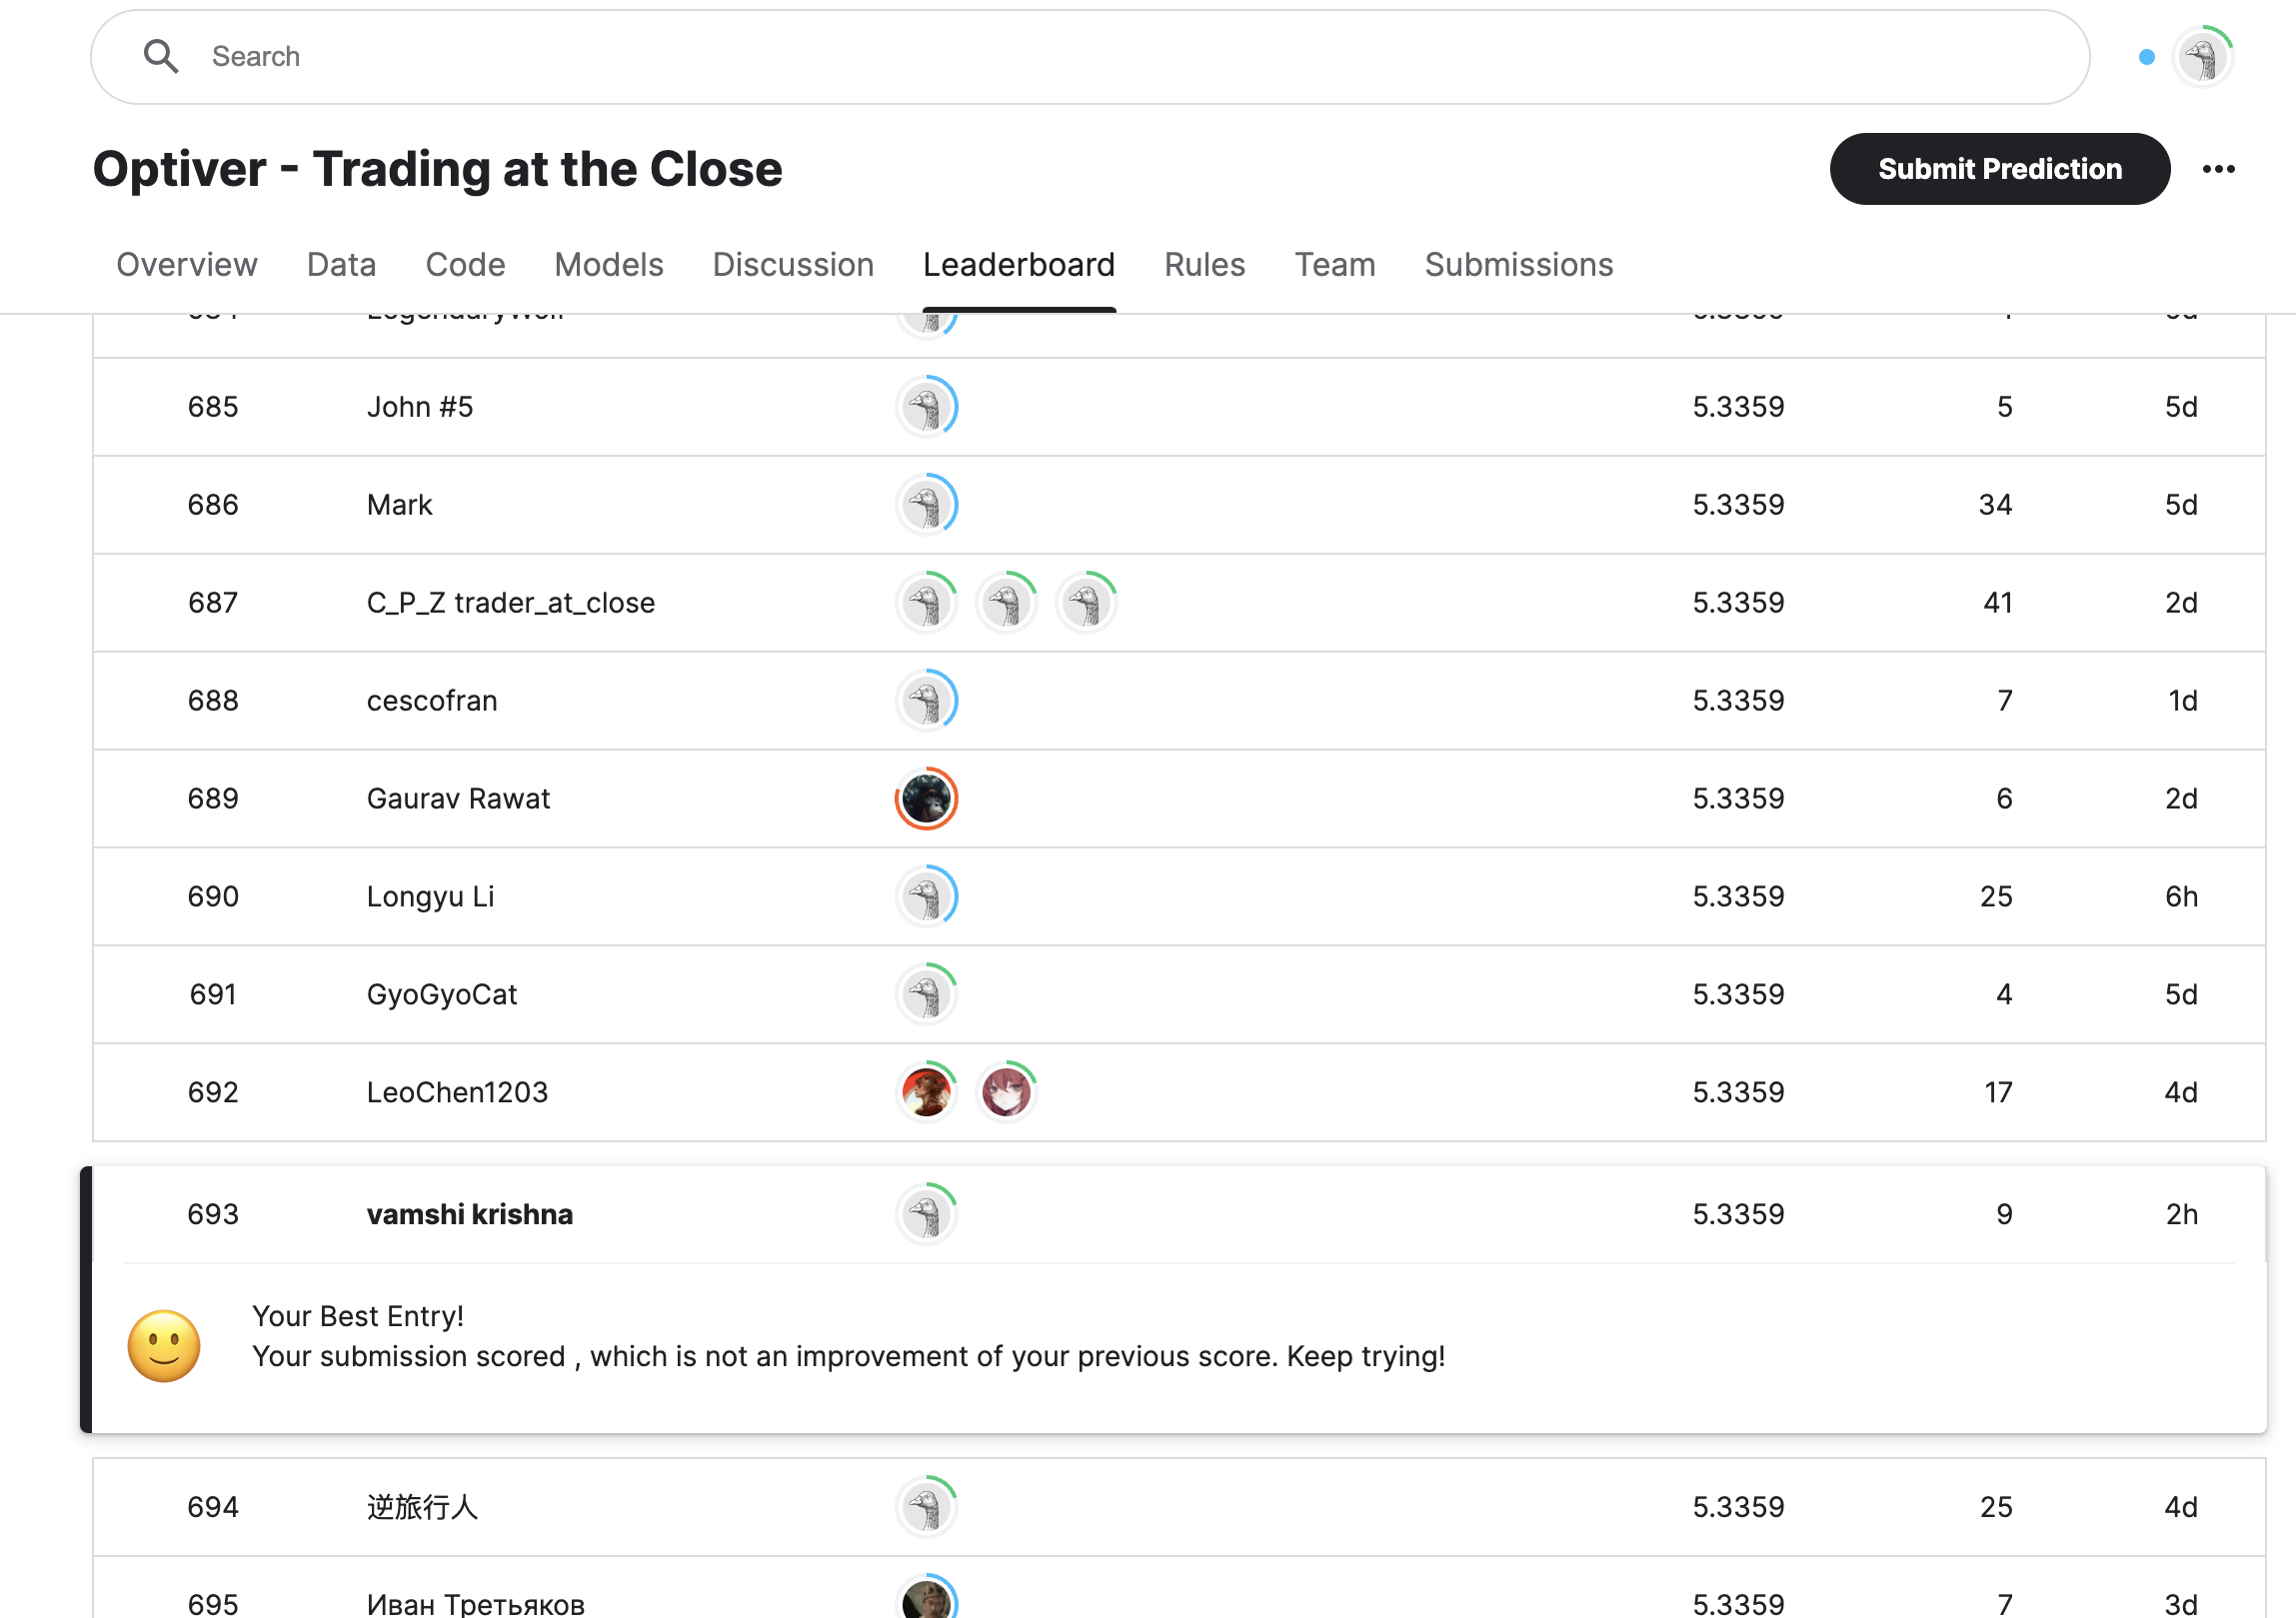

### The team achieved a rank of 693, and the project submission received a score of 5.3359. Participating in this Kaggle competition proved to be a valuable learning experience, contributing significantly to the enhancement of knowledge and skills.
